In [198]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from utils import set_plotting_style, get_chunking, get_chunking_dask

In [199]:
set_plotting_style()

In [200]:
try:
    from yahist import Hist1D, Hist2D
except:
    !pip install git+git://github.com/aminnj/yahist.git#egg=yahist -U
    from yahist import Hist1D, Hist2D

## Make dataframes

In [201]:
def make_df(fname):
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(["n*","pass_*",
                     "MET_*",
                     "/BS_(x|y|z)$/",
                     "/Jet_(pt|eta|phi|m)$/",
                     "/Muon_(pt|eta|phi|m|n.*|trackIso|charge|trk_qoverp.*|dxy.*|chi2|ndof|vx|vy|vz|jetIdx.*)$/",
                     "/DV_(tracksSize|chi2|ndof|rho.*|inPixel.*|x|y|z|xError|yError|zError)$/",
                     "run","luminosityBlock","event",
                    ],outputtype=dict,namedecode="ascii")
    
    # booleans for selection
    sel = (
        (arrs["nDV"] == 1) 
        & (arrs["nMuon"] == 2) 
        & arrs["pass_l1"] 
        & arrs["pass_skim"] 
        & arrs["pass_fiducialgen"]
        & (arrs["DV_rho"]>1.0).any()
    )

    # flatten into dataframe and require `sel`
    df = pd.DataFrame()
    for k in arrs.keys():
        if any(k.startswith(y) for y in ["n","pass_","BS_","MET_","run","lumi","event"]):
            df[k] = arrs[k][sel]
        if k.startswith("DV_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]
        if k.startswith("Jet_"):
            # make sure there is at least 1 jet per event, filled with 0s
            padded = arrs[k][sel].pad(1).fillna(0.)
            # convert index of -1 (no jet found) to at least 0, and then we will pick up the 
            # dummy 0s from the padded array
            vals = padded[np.maximum(arrs["Muon_jetIdx1"][sel],0)]
            df[k.replace("Jet_","Muon1_Jet_")] = vals[:,0]
            df[k.replace("Jet_","Muon2_Jet_")] = vals[:,1]

    # augment
    TLVA = uproot_methods.TLorentzVectorArray
    TV2A = uproot_methods.TVector2Array
    mu1 = TLVA.from_ptetaphim(df["Muon1_pt"],df["Muon1_eta"],df["Muon1_phi"],0.10566)
    mu2 = TLVA.from_ptetaphim(df["Muon2_pt"],df["Muon2_eta"],df["Muon2_phi"],0.10566)
    jetmu1 = TLVA.from_ptetaphim(df["Muon1_Jet_pt"],df["Muon1_Jet_eta"],df["Muon1_Jet_phi"],df["Muon1_Jet_m"])
    jetmu2 = TLVA.from_ptetaphim(df["Muon2_Jet_pt"],df["Muon2_Jet_eta"],df["Muon2_Jet_phi"],df["Muon2_Jet_m"])
    dimu = mu1+mu2
    df["dimuon_mass"] = dimu.mass
    df["dimuon_eta"] = dimu.eta
    df["dimuon_phi"] = dimu.phi
    df["dimuon_pt"] = dimu.pt
    vecdimu = TV2A.from_polar(dimu.pt,dimu.phi)
    vecdv = TV2A.from_cartesian(df["DV_x"]-df["BS_x"],df["DV_y"]-df["BS_y"])
    df["absdphimudv"] = np.abs(vecdimu.delta_phi(vecdv))
    df["absdphimumu"] = np.abs(mu1.delta_phi(mu2))
    df["cosphi"] = vecdimu.cosdelta(vecdv)
    df["angle3dmumu"] = np.arccos(mu1.p3.dot(mu2.p3)/(mu1.p3.mag*mu2.p3.mag))
    df["DV_redchi2"] = df["DV_chi2"]/df["DV_ndof"]
    df["DV_xyErrorMax"] = np.maximum(df["DV_xError"],df["DV_yError"])
    df["Muon1_redchi2"] = df["Muon1_chi2"]/df["Muon1_ndof"]
    df["Muon2_redchi2"] = df["Muon2_chi2"]/df["Muon2_ndof"]
    df["Muon1_adqpt"] = np.abs(df["Muon1_trk_qoverpError"]/df["Muon1_trk_qoverp"])
    df["Muon2_adqpt"] = np.abs(df["Muon2_trk_qoverpError"]/df["Muon2_trk_qoverp"])
    df["Muon1_m"] = 0.10566
    df["Muon2_m"] = 0.10566
    
    drs = mu1.delta_r(jetmu1)
    drs[jetmu1.pt<1] = 0.
    df["Muon1_drjet"] = drs
    df["Muon1_ptratio"] = (df["Muon1_pt"]/df["Muon1_Jet_pt"]).replace(np.inf,0.).fillna(0.)
    drs = mu2.delta_r(jetmu2)
    drs[jetmu2.pt<1] = 0.
    df["Muon2_drjet"] = drs
    df["Muon2_ptratio"] = (df["Muon2_pt"]/df["Muon2_Jet_pt"]).replace(np.inf,0.).fillna(0.)
    
    df["maxabsdxy"] = np.maximum(np.abs(df["Muon1_dxyCorr"]),np.abs(df["Muon2_dxyCorr"]))
    df["minabsdxy"] = np.minimum(np.abs(df["Muon1_dxyCorr"]),np.abs(df["Muon2_dxyCorr"]))
    df["maxdxy"] = np.maximum(df["Muon1_dxyCorr"],df["Muon2_dxyCorr"])
    df["mindxy"] = np.minimum(df["Muon1_dxyCorr"],df["Muon2_dxyCorr"])
    
    # skim more
    df = df.query(
        "(cosphi > 0.)"
        " and (Muon1_charge != Muon2_charge)"
        " and (DV_xyErrorMax < 0.05)"
        " and (DV_zError < 0.1)"
        " and (Muon1_nValidMuonHits > 0)"
        " and (Muon2_nValidMuonHits > 0)"
        " and (Muon1_redchi2 < 3)"
        " and (Muon2_redchi2 < 3)"
    )
    return df
    
df_data = pd.concat(
    map(make_df,glob.glob(
        "/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v4_unblind1fb_RAW_v6skim1cmjets/*.root"
    ))
).reset_index(drop=True)
df_mc = make_df("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v6//output_1.root").reset_index(drop=True)

/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in arccos


In [202]:
if True:
# if False:
    df_data.to_pickle("data/df_data.pkl")
    df_mc.to_pickle("data/df_mc.pkl")
else:
    df_data = pd.read_pickle("data/df_data.pkl")
    df_mc = pd.read_pickle("data/df_mc.pkl")

In [203]:
df_mc.head()

,nDV,nJet,nPV,nPVM,nMuon,nGenPart,nGenMuon,pass_skim,pass_l1,pass_fiducialgen,...,Muon1_adqpt,Muon2_adqpt,Muon1_drjet,Muon1_ptratio,Muon2_drjet,Muon2_ptratio,maxabsdxy,minabsdxy,maxdxy,mindxy
0,1,3,13,4,2,9,2,True,True,True,...,0.026885,0.040844,2.219298,1.422299,2.585459,0.373916,2.004623,0.543271,2.004623,-0.543271
1,1,0,8,2,2,10,2,True,True,True,...,0.040505,0.014735,0.000000,0.000000,0.000000,0.000000,1.116448,0.307861,0.307861,-1.116448
2,1,2,10,2,2,10,2,True,True,True,...,0.022248,0.020393,1.988988,1.147401,2.951698,0.690822,1.248943,0.704636,1.248943,-0.704636
3,1,0,12,2,2,13,2,True,True,True,...,0.010516,0.011159,0.000000,0.000000,0.000000,0.000000,1.807147,1.482357,1.807147,-1.482357
4,1,1,2,1,2,11,2,True,True,True,...,0.018653,0.011040,3.133152,1.109136,3.261350,0.181250,8.295023,1.362153,1.362153,-8.295023


In [190]:
df_data.columns

Index(['nDV', 'nPV', 'nPVM', 'nMuon', 'nGenPart', 'nGenMuon', 'pass_skim',
       'pass_l1', 'pass_fiducialgen', 'MET_pt', 'MET_phi', 'BS_x', 'BS_y',
       'BS_z', 'Muon1_pt', 'Muon2_pt', 'Muon1_eta', 'Muon2_eta', 'Muon1_phi',
       'Muon2_phi', 'Muon1_m', 'Muon2_m', 'Muon1_trackIso', 'Muon2_trackIso',
       'Muon1_chi2', 'Muon2_chi2', 'Muon1_ndof', 'Muon2_ndof', 'Muon1_charge',
       'Muon2_charge', 'Muon1_dxy', 'Muon2_dxy', 'Muon1_nValidMuonHits',
       'Muon2_nValidMuonHits', 'Muon1_nValidPixelHits',
       'Muon2_nValidPixelHits', 'Muon1_nMatchedStations',
       'Muon2_nMatchedStations', 'Muon1_nTrackerLayersWithMeasurement',
       'Muon2_nTrackerLayersWithMeasurement', 'Muon1_nValidStripHits',
       'Muon2_nValidStripHits', 'Muon1_trk_qoverp', 'Muon2_trk_qoverp',
       'Muon1_dxyError', 'Muon2_dxyError', 'Muon1_trk_qoverpError',
       'Muon2_trk_qoverpError', 'Muon1_vx', 'Muon2_vx', 'Muon1_vy', 'Muon2_vy',
       'Muon1_vz', 'Muon2_vz', 'Muon1_dxyCorr', 'Muon2_dxyCorr', 

## Plot dump

In [282]:
plotdir = "plots_split_v4/"
os.system("mkdir -p {}".format(plotdir))

selinfos = []

selinfos.append(dict(vsels=[
    ["all",lambda df: slice(None)],
],split_label = "splitnone"))

selinfos.append(dict(vsels=[
    ["near pix.",lambda df:  df["DV_inPixelRectangles"]],
    ["away pix.",lambda df: ~df["DV_inPixelRectangles"]],
],split_label = "splitpixel"))

selinfos.append(dict(vsels=[
    [r"dimuon $\eta$<0.9",lambda df:  np.abs(df["dimuon_eta"])<0.9],
    [r"dimuon $\eta$>0.9",lambda df: np.abs(df["dimuon_eta"])>0.9],
],split_label = "spliteta"))

selinfos.append(dict(vsels=[
    [r"dimuon $p_T$<20",lambda df: (df["dimuon_pt"]<20)],
    [r"20<dimuon $p_T$<50",lambda df:  (df["dimuon_pt"]<50) & (df["dimuon_pt"]>20)],
    [r"dimuon $p_T$>50",lambda df:  (df["dimuon_pt"]>50)],
],split_label = "splitpt"))

selinfos.append(dict(vsels=[
    [r"1.0<DV $\rho$<3.6",lambda df:  (np.abs(df["DV_rhoCorr"])<3.6) & (np.abs(df["DV_rhoCorr"])>1.0)],
    [r"3.6<DV $\rho$<7.3",lambda df:  (np.abs(df["DV_rhoCorr"])<7.3) & (np.abs(df["DV_rhoCorr"])>3.6)],
    [r"7.3<DV $\rho$<11.5",lambda df:  (np.abs(df["DV_rhoCorr"])<11.5) & (np.abs(df["DV_rhoCorr"])>7.3)],
],split_label = "splitrho"))

selinfos.append(dict(vsels=[
    ["mass<5",lambda df:  (df["dimuon_mass"]<5)],
    ["5<mass<10",lambda df:  (df["dimuon_mass"]<10) & (df["dimuon_mass"]>5)],
    ["mass>10",lambda df:  (df["dimuon_mass"]>10)],
],split_label = "splitmass"))

selinfos.append(dict(vsels=[
    ["|dphi(mu1,mu2)|<2.8",lambda df:  (df["absdphimumu"]<2.8)],
    ["|dphi(mu1,mu2)|>2.8",lambda df:  (df["absdphimumu"]>2.8)],
],split_label = "splitdphimumu"))

plots = [
    
    [[lambda df: df["Muon1_nValidPixelHits"],lambda df: df["Muon2_nValidPixelHits"]], np.arange(10)-0.5, dict(title="Muon nValidPixelHits",shortname="nValidPixelHits")],
    [[lambda df: df["Muon1_nValidStripHits"],lambda df: df["Muon2_nValidStripHits"]], np.arange(50)-0.5, dict(title="Muon nValidStripHits",shortname="nValidStripHits")],
    [[lambda df: df["Muon1_nExpectedPixelHits"],lambda df: df["Muon2_nExpectedPixelHits"]], np.arange(12)-0.5, dict(title="Muon nExpectedPixelHits",shortname="nExpectedPixelHits")],
    [[lambda df: df.eval("Muon1_nValidPixelHits-Muon1_nExpectedPixelHits"),lambda df: df.eval("Muon2_nValidPixelHits-Muon2_nExpectedPixelHits")], np.arange(10)-5.5, dict(title="Muon nValidPixelHits-nExpectedPixelHits",shortname="nValidMinusExpectedPixelHits")],
    
    [[lambda df: df["Muon1_nTrackerLayersWithMeasurement"],lambda df: df["Muon2_nTrackerLayersWithMeasurement"]], np.arange(20)-0.5, dict(title="Muon nTrackerLayersWithMeasurement",shortname="nTrackerLayers")],
    [[lambda df: df["Muon1_nMatchedStations"],lambda df: df["Muon2_nMatchedStations"]], np.arange(5)-0.5, dict(title="Muon nMatchedStations",shortname="nMatchedStations")],
    [[lambda df: df["Muon1_nValidMuonHits"],lambda df: df["Muon2_nValidMuonHits"]], np.arange(100)-0.5, dict(title="Muon nValidMuonHits",shortname="nValidMuonHits")],
    
    [[lambda df: df["Muon1_eta"],lambda df: df["Muon2_eta"]], np.linspace(-2.5,2.5,100), dict(title="Muon eta",shortname="eta")],
    [[lambda df: df["Muon1_phi"],lambda df: df["Muon2_phi"]], np.linspace(-3.2,3.2,100), dict(title="Muon phi",shortname="phi")],
    [[lambda df: df["Muon1_pt"],lambda df: df["Muon2_pt"]], np.linspace(0,100,100), dict(title="Muon pT",shortname="pt")],
    [[lambda df: np.abs(df["Muon1_dxyCorr"]),lambda df: np.abs(df["Muon2_dxyCorr"])], np.linspace(0.0,6,150), dict(title="abs(Muon dxy)",logy=True,logx=True,shortname="absdxy")],
    [[lambda df: df["Muon1_dxyCorr"],lambda df: df["Muon2_dxyCorr"]], np.linspace(-5,5,150), dict(title="(signed) Muon dxy",logy=True,shortname="signeddxy")],
    [[lambda df: df["maxdxy"]], np.linspace(-6,6,150), dict(title="max(Muon1 dxy, Muon2 dxy)",logy=True,shortname="maxdxy")],
    [[lambda df: df["mindxy"]], np.linspace(-6,6,150), dict(title="min(Muon1 dxy, Muon2 dxy)",logy=True,shortname="mindxy")],
    [[lambda df: df["maxabsdxy"]], np.linspace(-6,6,150), dict(title="max(abs(Muon1 dxy), abs(Muon2 dxy))",logy=True,shortname="maxabsdxy")],
    [[lambda df: df["minabsdxy"]], np.linspace(-6,6,150), dict(title="min(abs(Muon1 dxy), abs(Muon2 dxy))",logy=True,shortname="minabsdxy")],
    [[lambda df: df["Muon1_dxyError"],lambda df: df["Muon2_dxyError"]], np.linspace(0.001,0.02,150), dict(title="Muon dxy Error",logy=True,shortname="dxyError")],
    
    [[lambda df: df["Muon1_redchi2"],lambda df: df["Muon2_redchi2"]], np.linspace(0,5,100), dict(title="Muon chi2/ndof",shortname="Muonchi2")],
    [[lambda df: df["Muon1_adqpt"],lambda df: df["Muon2_adqpt"]], np.linspace(0,0.05,100), dict(title="Muon abs(qoverpError/qoverp)",shortname="relqoverp")],
    [[lambda df: df["Muon1_trackIso"],lambda df: df["Muon2_trackIso"]], np.linspace(0,5,100), dict(title="Muon trackIso",logy=True,shortname="trackIso")],
    [[lambda df: df["Muon1_ptratio"],lambda df: df["Muon2_ptratio"]], np.linspace(0,4,100), dict(title="Muon pT/closest jet pT",shortname="ptratio")],
    [[lambda df: df["Muon1_drjet"],lambda df: df["Muon2_drjet"]], np.linspace(0,2*np.pi,100), dict(title="dR(muon,closest jet)",shortname="drjet")],
    
    [[lambda df: df["DV_inPixelRectangles"]], np.linspace(-0.5,1.5,3), dict(title="Is in pixel rectangle?",shortname="inPixel")],
    [[lambda df: df["DV_rhoCorr"]], np.linspace(0.1,12,200), dict(title="DV rho",logy=True,shortname="rho")],
    [[lambda df: df["absdphimumu"]], np.linspace(0,3.1416,150), dict(title="abs(dphi(mu1,mu2))",shortname="dphimumu")],
    [[lambda df: df["absdphimumu"]], np.linspace(0,3.1416,150), dict(title="abs(dphi(mu1,mu2)), logscale",logx=True,logy=True,shortname="dphimumulog")],
    [[lambda df: df["absdphimudv"]], np.linspace(0,0.1,100), dict(title="abs(dphi(dimuon,DV))",shortname="dphimudv")],
    [[lambda df: df["dimuon_mass"]], np.linspace(0.2,50,300), dict(title="Dimuon mass",logy=True,logx=True,shortname="mass")],
    [[lambda df: df["dimuon_pt"]], np.linspace(0,100,200), dict(title="Dimuon pT",shortname="dimuonpt")],
    
    [[lambda df: df["DV_zError"]], np.linspace(0.0,0.2,100), dict(title="DV zError",shortname="zError")],
    [[lambda df: df["DV_xyErrorMax"]], np.linspace(0.0,0.2,100), dict(title="DV max(xError,yError)",shortname="xyErrorMax")],
    [[lambda df: df["DV_redchi2"]], np.linspace(0.0,10.0,100), dict(title="DV chi2/ndof",shortname="DVchi2")],
    [[lambda df: np.log10(df["DV_redchi2"])], np.linspace(-5,1.5,100), dict(title="DV log10(chi2/ndof)",shortname="DVlogchi2")],
    
    [[lambda df: df["nPV"]], np.arange(40)-0.5, dict(title="nPV (from hltPixelVertices)",shortname="nPV")],
    [[lambda df: df["nPVM"]], np.arange(15)-0.5, dict(title="nPVM (from hltPixelVerticesL3MuonNoVtx)",shortname="nPVM")],
    [[lambda df: df["nJet"]], np.arange(15)-0.5, dict(title="nJet",shortname="njets")],
    
    [[lambda df: df["angle3dmumu"]], np.linspace(0,3.142,100), dict(title="3d angle between mu1 and mu2",shortname="angle3dmumu")],
]

# plots = [
#     [[lambda df: df["angle3dmumu"]], np.linspace(0,3.142,100), dict(title="3d angle between mu1 and mu2",shortname="angle3dmumu")],
#     [[lambda df: df["DV_zError"]], np.linspace(0.0,0.2,100), dict(title="DV zError",shortname="zError")],
# ]

for selinfo in selinfos:
    vsels = selinfo["vsels"]
    split_label = selinfo["split_label"]
    
    for fs,bins,opts in plots:
        fig,ax = plt.subplots()

        ymax = 0.
        for df,label,linestyle in [
            [df_mc,"mc","--"],
            [df_data,"data","-"],
        ]:
            

            for (sel_label,fsel),color in zip(vsels,["C0","C3","C2","C1"]):
                
                # skip low stats MC splits
                if (label == "mc") and (("mass<5" in sel_label) or ("mass<10" in sel_label)): continue
                
                sel = fsel(df)
                h = sum([Hist1D(f(df)[sel],bins=bins) for f in fs]).normalize()
                h.plot(ax=ax,label="{} ({})".format(label,sel_label),color=color,histtype="step",linestyle=linestyle);
                ymax = max(ymax,h.counts.max())

        if opts.get("logx"):
            ax.set_xscale("log")

        if opts.get("logy"):
            ax.set_ylim(0.00001,ymax*1.5)
            ax.set_yscale("log")
        else:
            ax.set_ylim(ax.get_ylim()[0],ymax*1.2)

        ax.set_title(opts.get("title",""))
        
        ax.legend()
        
        shortname = opts.get("shortname","unknown")
        fname = "{}/{}_{}.png".format(plotdir,split_label,shortname)
        print(fname)
#     break
        fig.set_tight_layout(True)
        fig.savefig(fname,dpi=150)
        
        # Don't show the figure in the notebook
        plt.close()
#         break

plots_split_v4//splitnone_nValidPixelHits.png
plots_split_v4//splitnone_nValidStripHits.png
plots_split_v4//splitnone_nExpectedPixelHits.png
plots_split_v4//splitnone_nValidMinusExpectedPixelHits.png
plots_split_v4//splitnone_nTrackerLayers.png
plots_split_v4//splitnone_nMatchedStations.png
plots_split_v4//splitnone_nValidMuonHits.png
plots_split_v4//splitnone_eta.png
plots_split_v4//splitnone_phi.png
plots_split_v4//splitnone_pt.png
plots_split_v4//splitnone_absdxy.png
plots_split_v4//splitnone_signeddxy.png
plots_split_v4//splitnone_maxdxy.png
plots_split_v4//splitnone_mindxy.png
plots_split_v4//splitnone_maxabsdxy.png
plots_split_v4//splitnone_minabsdxy.png
plots_split_v4//splitnone_dxyError.png
plots_split_v4//splitnone_Muonchi2.png
plots_split_v4//splitnone_relqoverp.png
plots_split_v4//splitnone_trackIso.png
plots_split_v4//splitnone_ptratio.png
plots_split_v4//splitnone_drjet.png
plots_split_v4//splitnone_inPixel.png


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


plots_split_v4//splitnone_rho.png
plots_split_v4//splitnone_dphimumu.png
plots_split_v4//splitnone_dphimumulog.png
plots_split_v4//splitnone_dphimudv.png
plots_split_v4//splitnone_mass.png
plots_split_v4//splitnone_dimuonpt.png
plots_split_v4//splitnone_zError.png
plots_split_v4//splitnone_xyErrorMax.png
plots_split_v4//splitnone_DVchi2.png
plots_split_v4//splitnone_nPV.png
plots_split_v4//splitnone_nPVM.png
plots_split_v4//splitnone_njets.png
plots_split_v4//splitnone_angle3dmumu.png
plots_split_v4//splitpixel_nValidPixelHits.png
plots_split_v4//splitpixel_nValidStripHits.png
plots_split_v4//splitpixel_nExpectedPixelHits.png
plots_split_v4//splitpixel_nValidMinusExpectedPixelHits.png
plots_split_v4//splitpixel_nTrackerLayers.png
plots_split_v4//splitpixel_nMatchedStations.png
plots_split_v4//splitpixel_nValidMuonHits.png
plots_split_v4//splitpixel_eta.png
plots_split_v4//splitpixel_phi.png
plots_split_v4//splitpixel_pt.png
plots_split_v4//splitpixel_absdxy.png
plots_split_v4//splitpix

plots_split_v4//splitdphimumu_minabsdxy.png
plots_split_v4//splitdphimumu_dxyError.png
plots_split_v4//splitdphimumu_Muonchi2.png
plots_split_v4//splitdphimumu_relqoverp.png
plots_split_v4//splitdphimumu_trackIso.png
plots_split_v4//splitdphimumu_ptratio.png
plots_split_v4//splitdphimumu_drjet.png
plots_split_v4//splitdphimumu_inPixel.png
plots_split_v4//splitdphimumu_rho.png
plots_split_v4//splitdphimumu_dphimumu.png
plots_split_v4//splitdphimumu_dphimumulog.png
plots_split_v4//splitdphimumu_dphimudv.png
plots_split_v4//splitdphimumu_mass.png
plots_split_v4//splitdphimumu_dimuonpt.png
plots_split_v4//splitdphimumu_zError.png
plots_split_v4//splitdphimumu_xyErrorMax.png
plots_split_v4//splitdphimumu_DVchi2.png
plots_split_v4//splitdphimumu_nPV.png
plots_split_v4//splitdphimumu_nPVM.png
plots_split_v4//splitdphimumu_njets.png
plots_split_v4//splitdphimumu_angle3dmumu.png


In [119]:
# Hist2D(df_data[["DV_x","DV_y"]].values,bins=np.linspace(-12,12,100)) #.plot(logz=True)
# Hist2D(df_mc[["DV_x","DV_y"]].values,bins=np.linspace(-12,12,100)) #.plot(logz=True)

In [283]:
with open("plots_split_v4/description.txt","w") as fh:
    fh.write("""
Selection: ==2 OS muons, ==1 DV, DV rho>1cm, cos(dphi(dimuon,DV))>0, max(DV_xError,yError)<0.05cm, DV_zError<0.1cm, # valid muon hits>0 for each muon<br>
Split plots by:
<ul>
<li>nothing ("splitnone_")</li>
<li>near or away from pixel material ("splitpixel_")</li>
<li>DV rho ("splitrho_")</li>
<li>eta of dimuon system ("spliteta_")</li>
<li>pT of dimuon system ("splitpt_")</li>
<li>mass of dimuon system ("splitmass_")</li>
<li>dphi(mu1,mu2) ("splitdphimumu_")</li>
</ul>
    """)
!niceplots plots_split_v4

Not converting anything
ln: creating symbolic link `plots_split_v4/index.php': File exists
uaf-10.t2.ucsd.edu/~namin/dump/plots/plots_split_v4/


## Check muon chi2

In [35]:
def get_pteta_weights(pts_sig,etas_sig,pts_bkg,etas_bkg,ptbins=None,etabins=None):
    """
    Takes arrays of pts, etas, is_signal bools, and optional pt/eta bins
    and returns an array of weights matching pts.shape with 1 for signal,
    reweighting bkg to signal
    """
    if ptbins is None:
        ptbins = np.array(list(range(0,20,2))+list(range(20,40,3))+list(range(40,100,5))+[150,200,5000])
    if etabins is None:
        etabins = np.linspace(-2.5,2.5,11)
    counts_sig, _,_ = np.histogram2d(pts_sig,etas_sig,bins=[ptbins,etabins])
    counts_bkg, _,_ = np.histogram2d(pts_bkg,etas_bkg,bins=[ptbins,etabins])
    ptidxs = np.digitize(pts_bkg,ptbins)-1
    etaidxs = np.digitize(etas_bkg,etabins)-1
    weights_bkg = (1.0*counts_sig[ptidxs,etaidxs]/counts_bkg[ptidxs,etaidxs])
    return weights_bkg

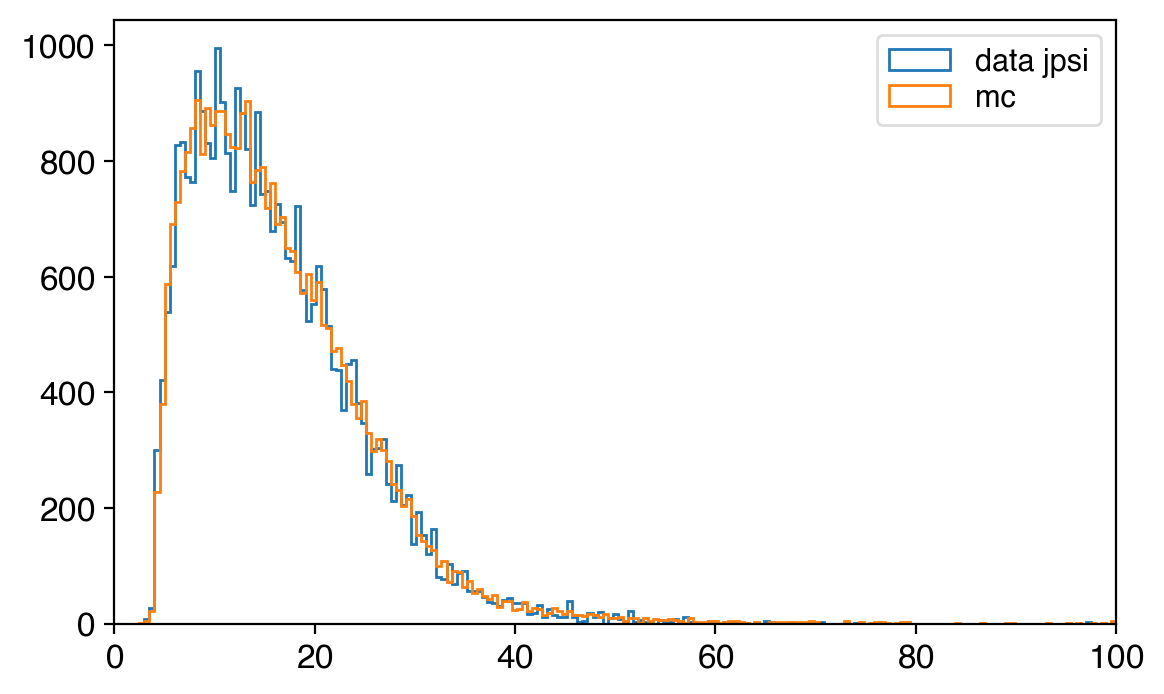

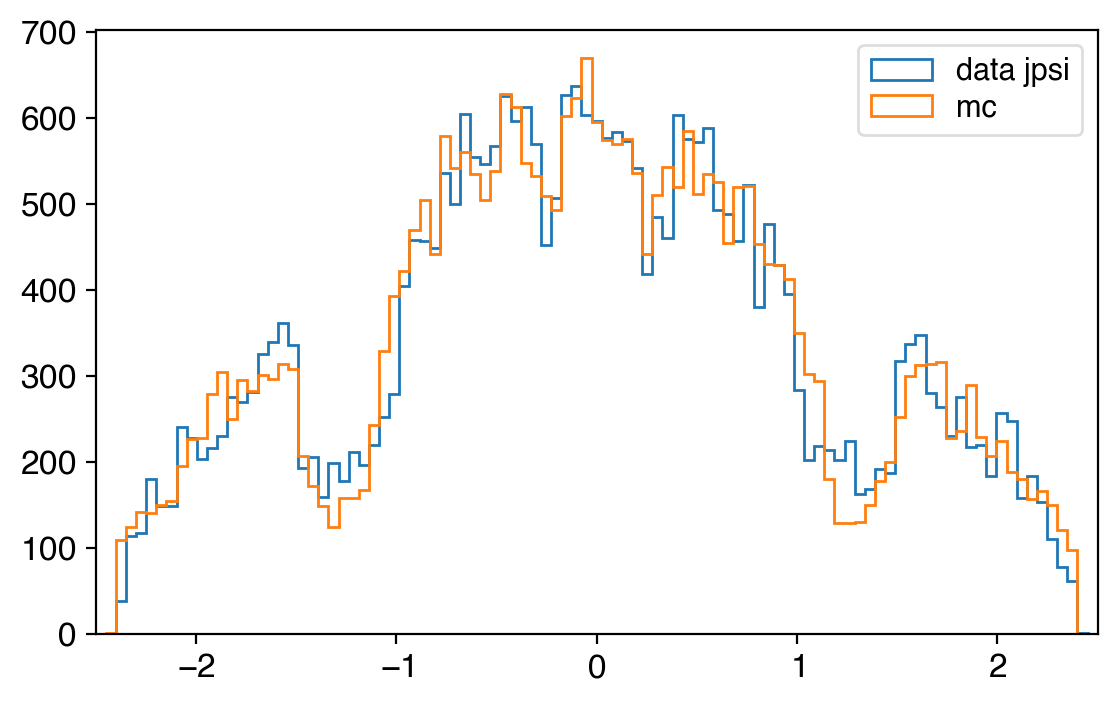

In [36]:
df_on = df_data.query("(2.95<dimuon_mass<3.2)")

weights = get_pteta_weights(
    df_mc["Muon2_pt"],
    df_mc["Muon2_eta"],
    df_on["Muon2_pt"],
    df_on["Muon2_eta"],
)
# Hist1D(weights,bins=np.linspace(0.,100,100)).plot()
# is_signal

fig, ax = plt.subplots()
Hist1D(df_on["Muon2_pt"],bins=np.linspace(0,100,200),weights=weights).plot(histtype="step",label="data jpsi")
Hist1D(df_mc["Muon2_pt"],bins=np.linspace(0,100,200)).plot(histtype="step",label="mc")
ax.legend()

fig, ax = plt.subplots()
Hist1D(df_on["Muon2_eta"],bins=np.linspace(-2.5,2.5,100),weights=weights).plot(histtype="step",label="data jpsi")
Hist1D(df_mc["Muon2_eta"],bins=np.linspace(-2.5,2.5,100)).plot(histtype="step",label="mc")
ax.legend()

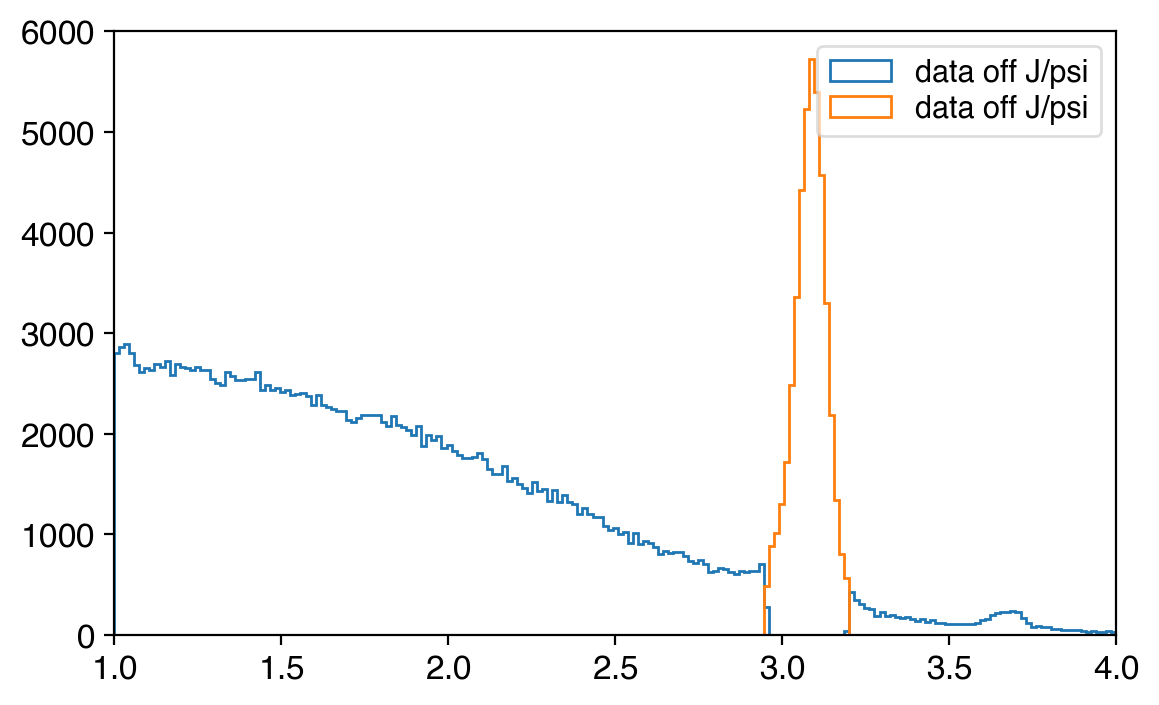

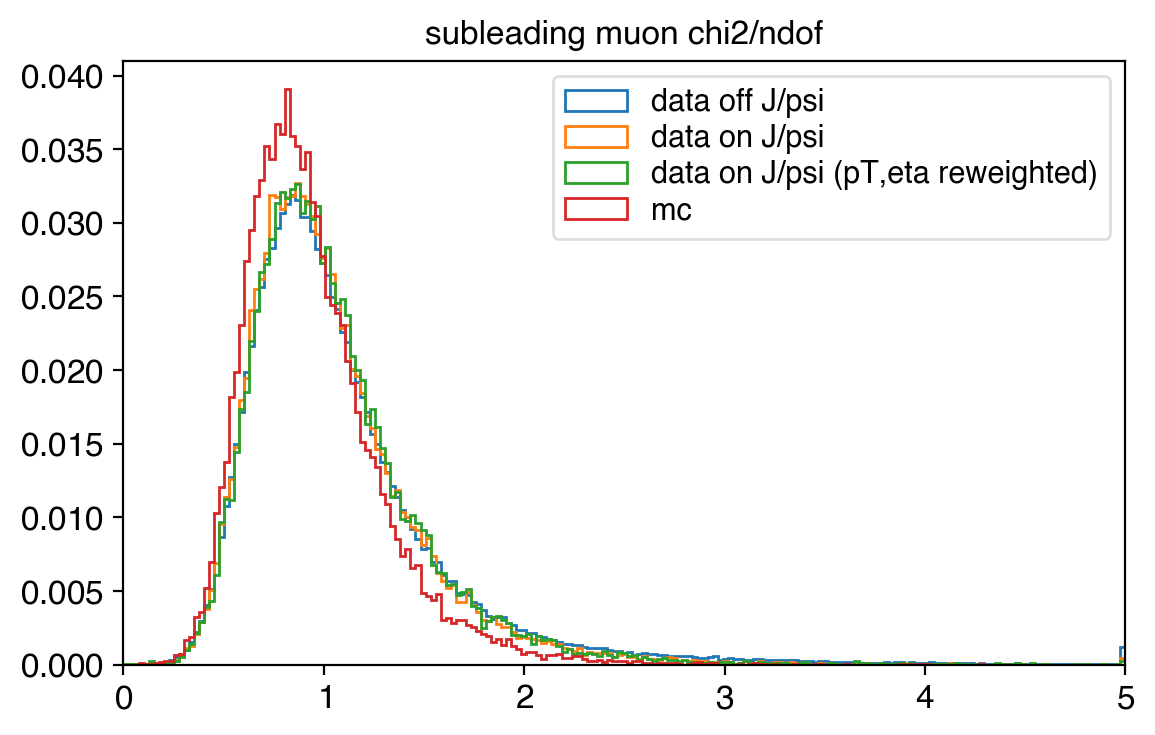

In [39]:
df_off = df_data.query("(1<dimuon_mass<4) and not (2.95<dimuon_mass<3.2)")
df_on = df_data.query("(2.95<dimuon_mass<3.2)")

fig, ax = plt.subplots()
Hist1D(df_off["dimuon_mass"],bins=np.linspace(1,4,200)).plot(label="data off J/psi",histtype="step")
Hist1D(df_on["dimuon_mass"],bins=np.linspace(1,4,200)).plot(label="data off J/psi",histtype="step")
ax.legend()

fig, ax = plt.subplots()
Hist1D(df_off["Muon2_redchi2"],bins=np.linspace(0,5,200)).normalize().plot(ax=ax,histtype="step",label="data off J/psi")
Hist1D(df_on["Muon2_redchi2"],bins=np.linspace(0,5,200)).normalize().plot(ax=ax,histtype="step",label="data on J/psi")
Hist1D(df_on["Muon2_redchi2"],weights=weights,bins=np.linspace(0,5,200)).normalize().plot(ax=ax,histtype="step",label="data on J/psi (pT,eta reweighted)")
Hist1D(df_mc["Muon2_redchi2"],bins=np.linspace(0,5,200)).normalize().plot(ax=ax,histtype="step",label="mc")
ax.set_title("subleading muon chi2/ndof")
ax.legend()

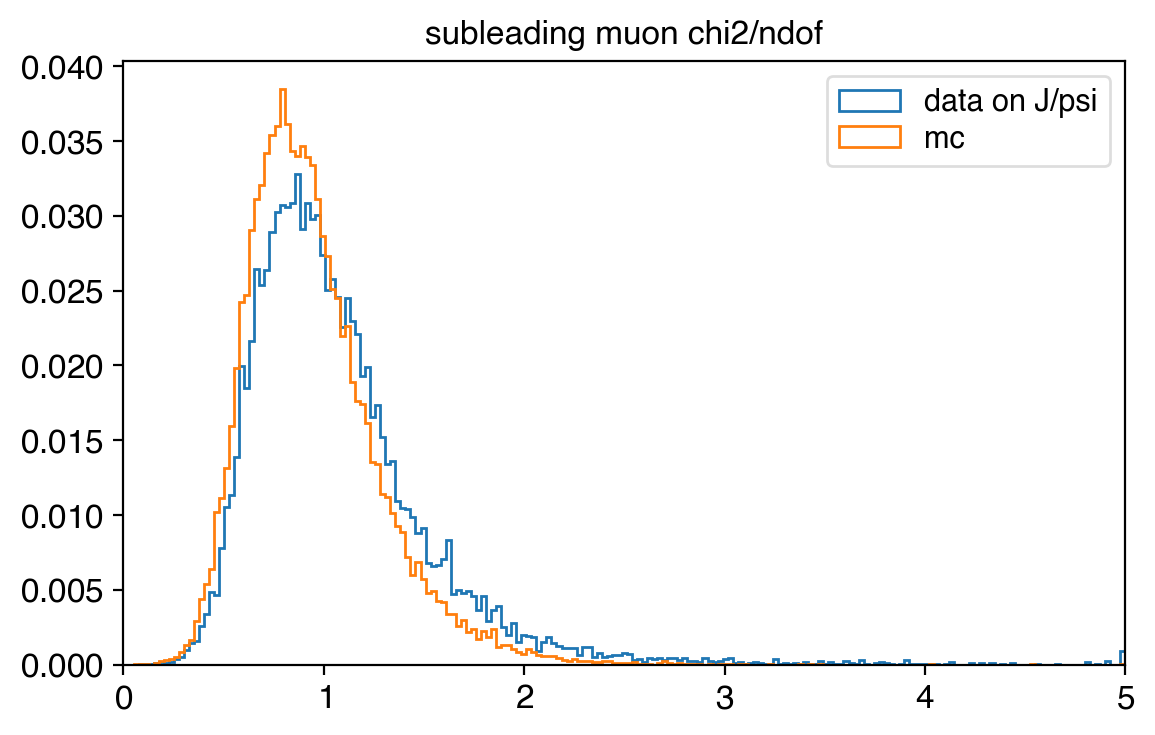

In [29]:
fig, ax = plt.subplots()
Hist1D(df_on["Muon1_redchi2"],weights=weights,bins=np.linspace(0,5,200)).normalize().plot(ax=ax,histtype="step",label="data on J/psi")
Hist1D(df_mc["Muon1_redchi2"],bins=np.linspace(0,5,200)).normalize().plot(ax=ax,histtype="step",label="mc")
ax.set_title("subleading muon chi2/ndof")
ax.legend()

## Check muon track iso

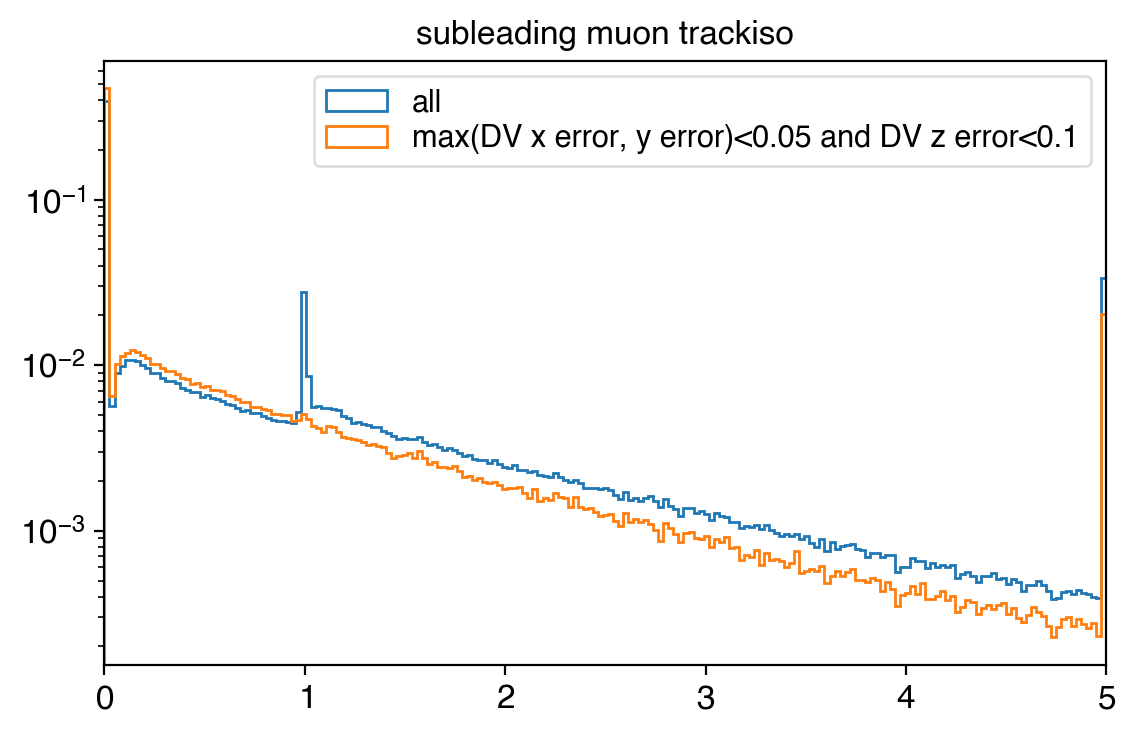

In [93]:
Hist1D(df_data["Muon2_trackIso"],bins=np.linspace(0,5,200)).normalize().plot(label="all",histtype="step")
Hist1D(df_data.query("DV_xyErrorMax<0.05 and DV_zError<0.1")["Muon2_trackIso"],bins=np.linspace(0,5,200)).normalize().plot(label="max(DV x error, y error)<0.05 and DV z error<0.1",histtype="step")
ax = plt.gca()
ax.set_yscale("log")
ax.set_title("subleading muon trackiso")
ax.legend()


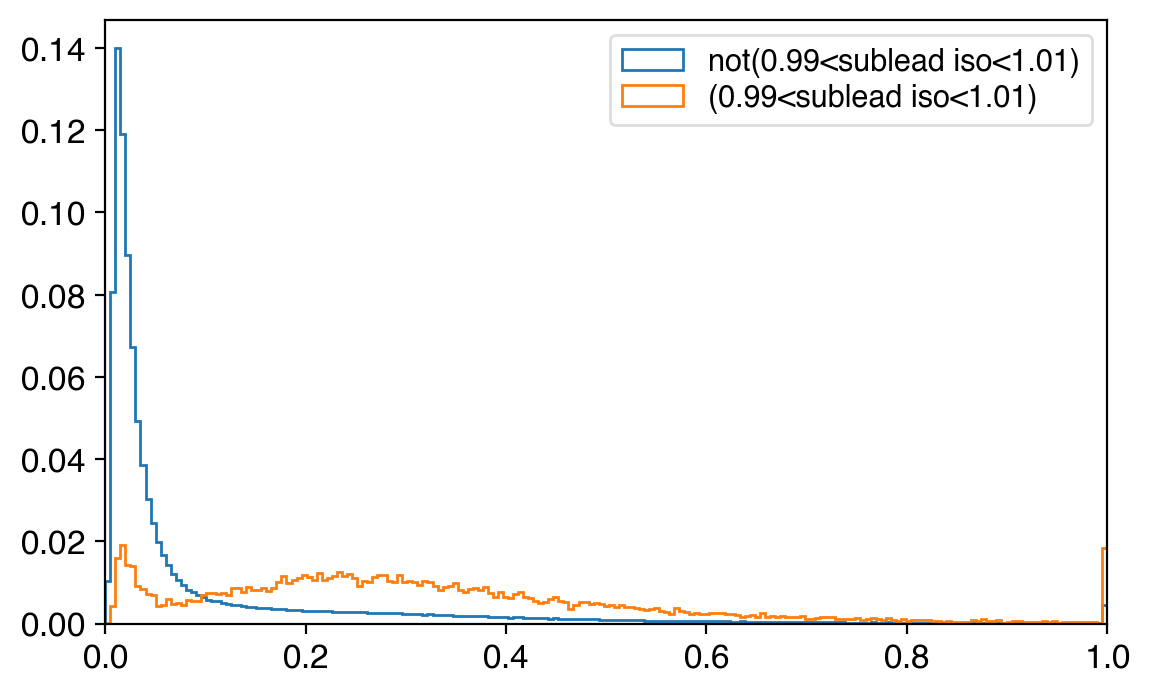

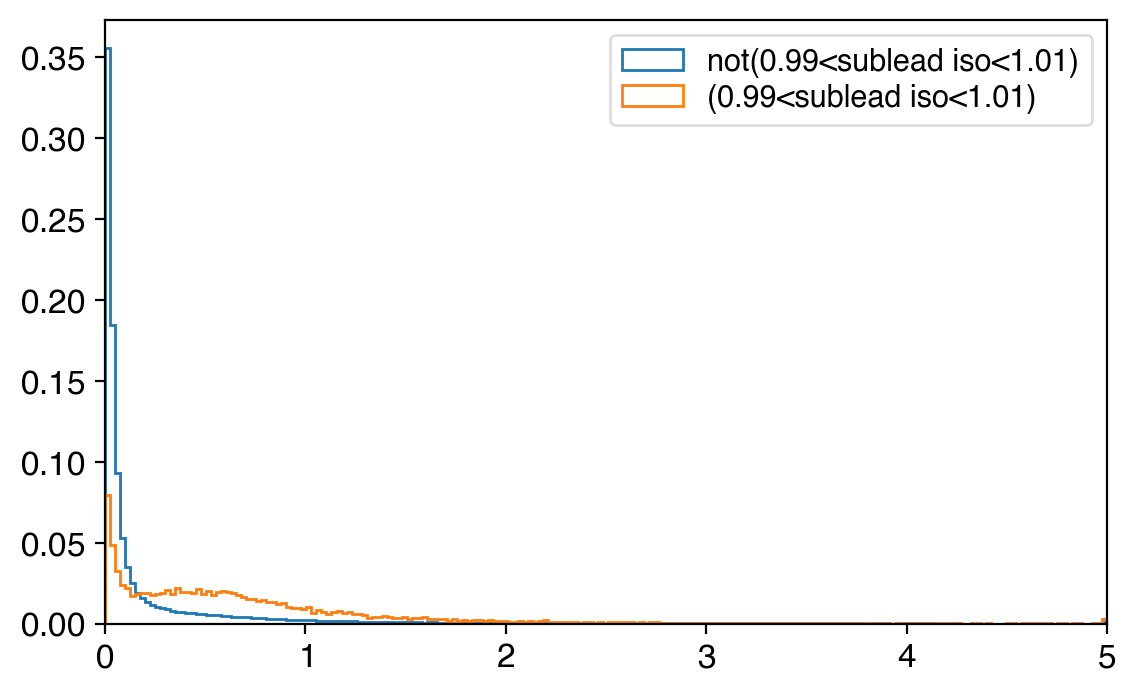

In [87]:
bins = np.linspace(0,1,200)
fig, ax = plt.subplots()
Hist1D(df_data.query("not(0.99<Muon2_trackIso<1.01)")["DV_xyErrorMax"],bins=bins).normalize().plot(label="not(0.99<sublead iso<1.01)",histtype="step")
Hist1D(df_data.query("0.99<Muon2_trackIso<1.01")["DV_xyErrorMax"],bins=bins).normalize().plot(label="(0.99<sublead iso<1.01)",histtype="step")
ax.legend()
# plt.gca().set_yscale("log")

bins = np.linspace(0,5,200)
fig, ax = plt.subplots()
Hist1D(df_data.query("not(0.99<Muon2_trackIso<1.01)")["DV_zError"],bins=bins).normalize().plot(label="not(0.99<sublead iso<1.01)",histtype="step")
Hist1D(df_data.query("0.99<Muon2_trackIso<1.01")["DV_zError"],bins=bins).normalize().plot(label="(0.99<sublead iso<1.01)",histtype="step")
ax.legend()

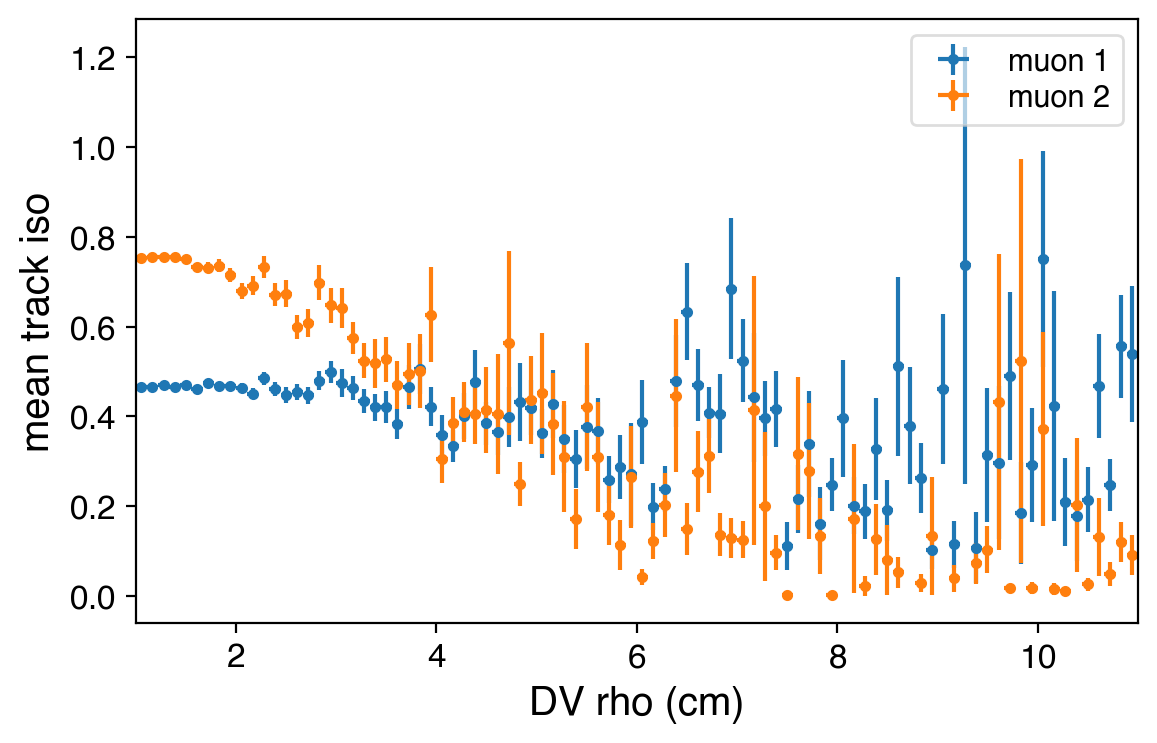

In [33]:
from utils import make_profile
bins = np.linspace(0,11,100)

df = df_data
h1 = make_profile(tobin=df["DV_rho"],toreduce=df["Muon1_trackIso"],edges=bins,errors=True)
h2 = make_profile(tobin=df["DV_rho"],toreduce=df["Muon2_trackIso"],edges=bins,errors=True)
h1.plot(show_errors=True,label="muon 1",markersize=3.0)
h2.plot(show_errors=True,label="muon 2",markersize=3.0)
ax = plt.gca()
ax.set_ylabel("mean track iso")
ax.set_xlabel("DV rho (cm)")
ax.legend()


## Cutflow

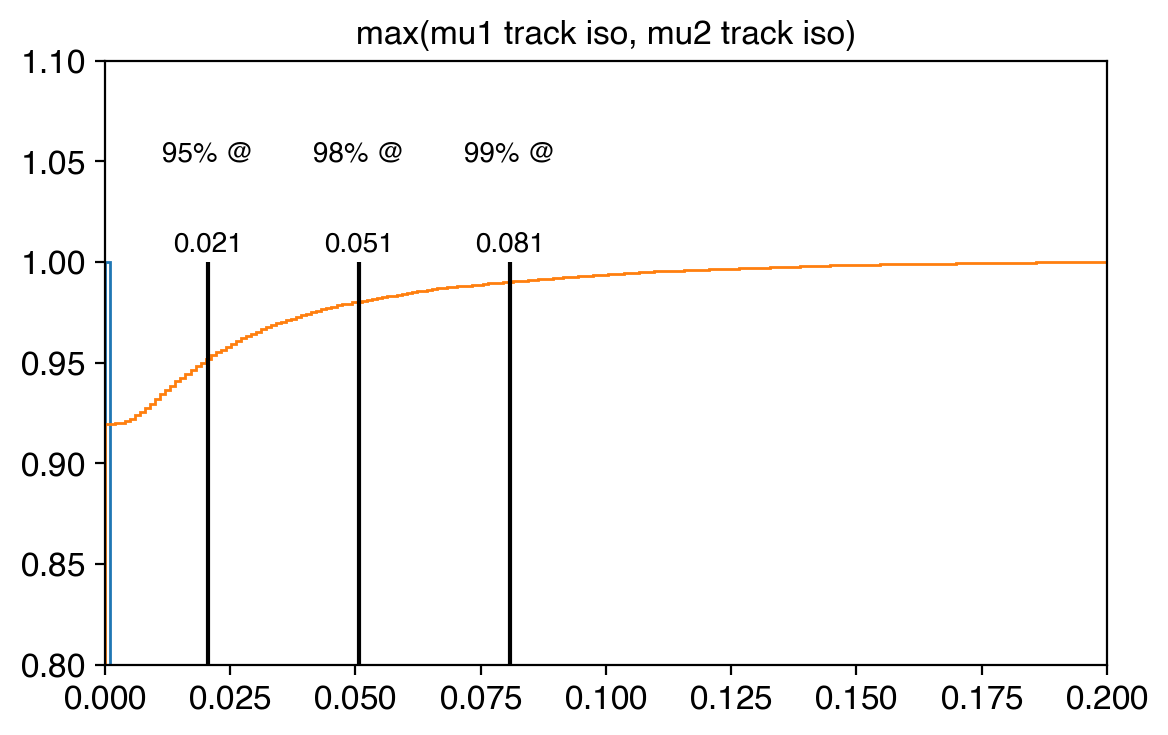

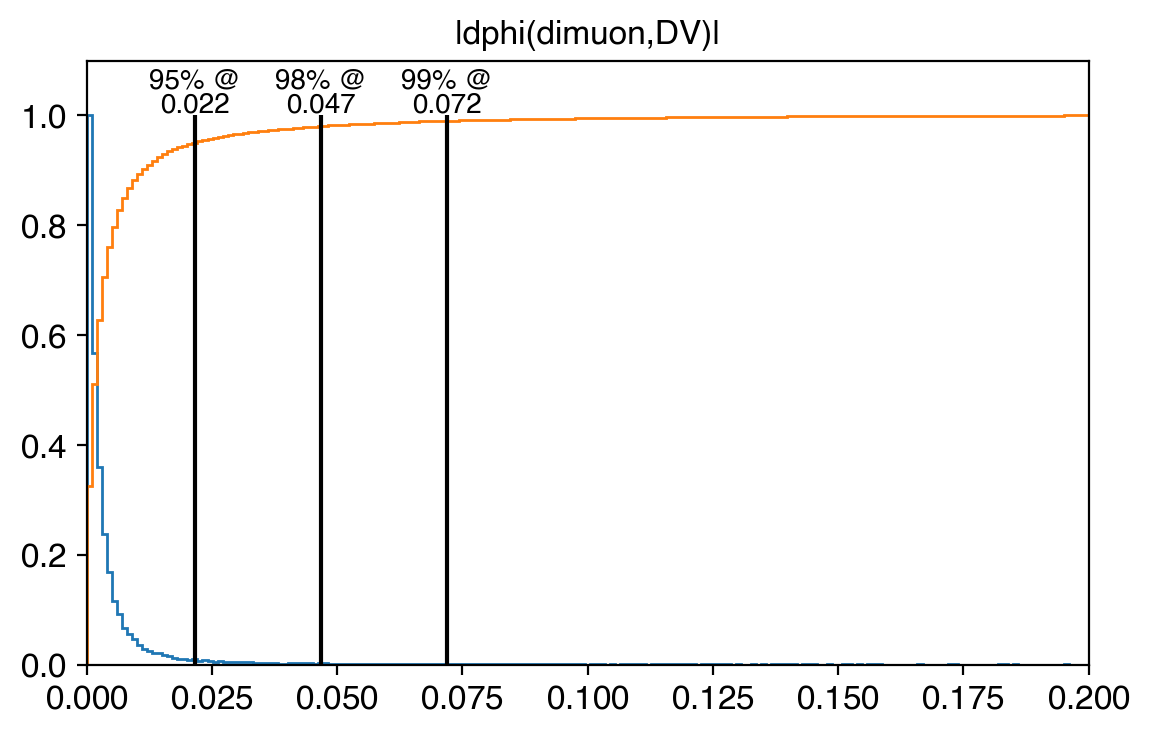

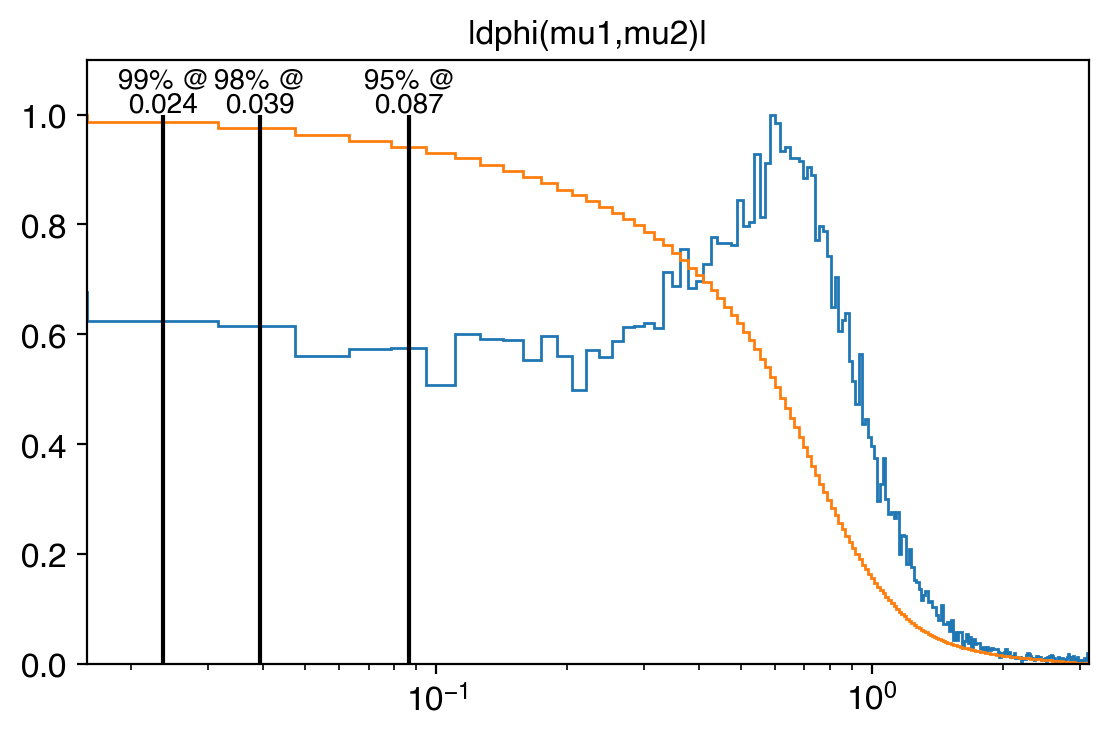

In [162]:
# cut_left = False # cut point marks stuff to left as "bad"

# NOTE for dphimumu, also want to require maybe <3.0 to kill back-to-back peak in data
infos = [
    (
        Hist1D(np.maximum(df_mc["Muon1_trackIso"],df_mc["Muon2_trackIso"]),bins=np.linspace(0,0.2,200),overflow=False).normalize(), 
        False,
        dict(title="max(mu1 track iso, mu2 track iso)",ymin=0.8)
    ),
    (
        Hist1D(df_mc["absdphimudv"],bins=np.linspace(0,0.2,200),overflow=False).normalize(),
        False,
        dict(title="|dphi(dimuon,DV)|")
    ),
    (
        Hist1D(df_mc["absdphimumu"],bins=np.linspace(0,np.pi,200),overflow=False).normalize(),
        True,
        dict(title="|dphi(mu1,mu2)|",logx=True)
    ),
]

for h, flip, extra in infos:

    fig, ax = plt.subplots()
    (h/h.counts.max()).plot(ax=ax,histtype="step")
    if flip:
        h._counts[::-1] = h._counts[::-1].cumsum()
    else:
        h._counts = h._counts.cumsum()
    h.plot(ax=ax,histtype="step")
    ax.set_ylim(extra.get("ymin"),1.1)
    # ax.set_ylim(0.8)
    # ax.vlines(h.counts[np.where(h.counts>0.95)[0][0]], ymin=0,ymax=1)
    fracs = [0.95,0.98,0.99]
    # fracs = [0.80]
    for frac in fracs:
    #     if cut_left:
    #         x = h.bin_centers[::-1][h.counts[::-1]>frac][0]
    #     else:
        if flip:
            x = h.bin_centers[h.counts<frac][0]
        else:
            x = h.bin_centers[h.counts>frac][0]
        ax.vlines(x, ymin=0, ymax=1)
        ax.text(x, 1.05, "{:g}% @".format(100*frac), ha="center")
        ax.text(x, 1.005, "{:.3f}".format(x), ha="center")
    ax.set_title(extra["title"])
    if extra.get("logx"):
        ax.set_xscale("log")
    # ax.set_yscale("log")
    # ax.set_ylim(0.8)

In [100]:
h.bin_centers[h.counts>0.95][0]

0.020603015075376888

In [127]:
Hist1D(np.pi-df_mc["absdphimumu"],bins=np.linspace(0,np.pi,100))

[20.000 ± 4.472   9.000 ± 3.000   9.000 ± 3.000   7.000 ± 2.646
 8.000 ± 2.828   10.000 ± 3.162   9.000 ± 3.000   12.000 ± 3.464
 10.000 ± 3.162   11.000 ± 3.317   18.000 ± 4.243   6.000 ± 2.449
 9.000 ± 3.000   9.000 ± 3.000   12.000 ± 3.464   5.000 ± 2.236
 12.000 ± 3.464   18.000 ± 4.243   19.000 ± 4.359   9.000 ± 3.000
 11.000 ± 3.317   9.000 ± 3.000   13.000 ± 3.606   16.000 ± 4.000
 10.000 ± 3.162   11.000 ± 3.317   20.000 ± 4.472   21.000 ± 4.583
 12.000 ± 3.464   8.000 ± 2.828   14.000 ± 3.742   15.000 ± 3.873
 19.000 ± 4.359   20.000 ± 4.472   22.000 ± 4.690   26.000 ± 5.099
 22.000 ± 4.690   24.000 ± 4.899   33.000 ± 5.745   33.000 ± 5.745
 38.000 ± 6.164   31.000 ± 5.568   34.000 ± 5.831   38.000 ± 6.164
 52.000 ± 7.211   47.000 ± 6.856   57.000 ± 7.550   48.000 ± 6.928
 62.000 ± 7.874   61.000 ± 7.810   71.000 ± 8.426   92.000 ± 9.592
 89.000 ± 9.434   116.000 ± 10.770   100.000 ± 10.000   138.000 ± 11.747
 144.000 ± 12.000   157.000 ± 12.530   157.000 ± 12.530   204.000 ± 14.283
 233.000 ± 15.264   291.000 ± 17.059   271.000 ± 16.462   336.000 ± 18.330
 366.000 ± 19.131   413.000 ± 20.322   409.000 ± 20.224   483.000 ± 21.977
 549.000 ± 23.431   626.000 ± 25.020   640.000 ± 25.298   776.000 ± 27.857
 799.000 ± 28.267   835.000 ± 28.896   975.000 ± 31.225
 1003.000 ± 31.670   1109.000 ± 33.302   1135.000 ± 33.690
 1156.000 ± 34.000   1178.000 ± 34.322   1184.000 ± 34.409
 1083.000 ± 32.909   1002.000 ± 31.654   998.000 ± 31.591
 932.000 ± 30.529   954.000 ± 30.887   820.000 ± 28.636   910.000 ± 30.166
 820.000 ± 28.636   756.000 ± 27.495   743.000 ± 27.258   704.000 ± 26.533
 655.000 ± 25.593   710.000 ± 26.646   729.000 ± 27.000   684.000 ± 26.153
 704.000 ± 26.533   728.000 ± 26.981   804.000 ± 28.355]

## Expected pixel hits

Text(0, 0.5, '$\\phi$')

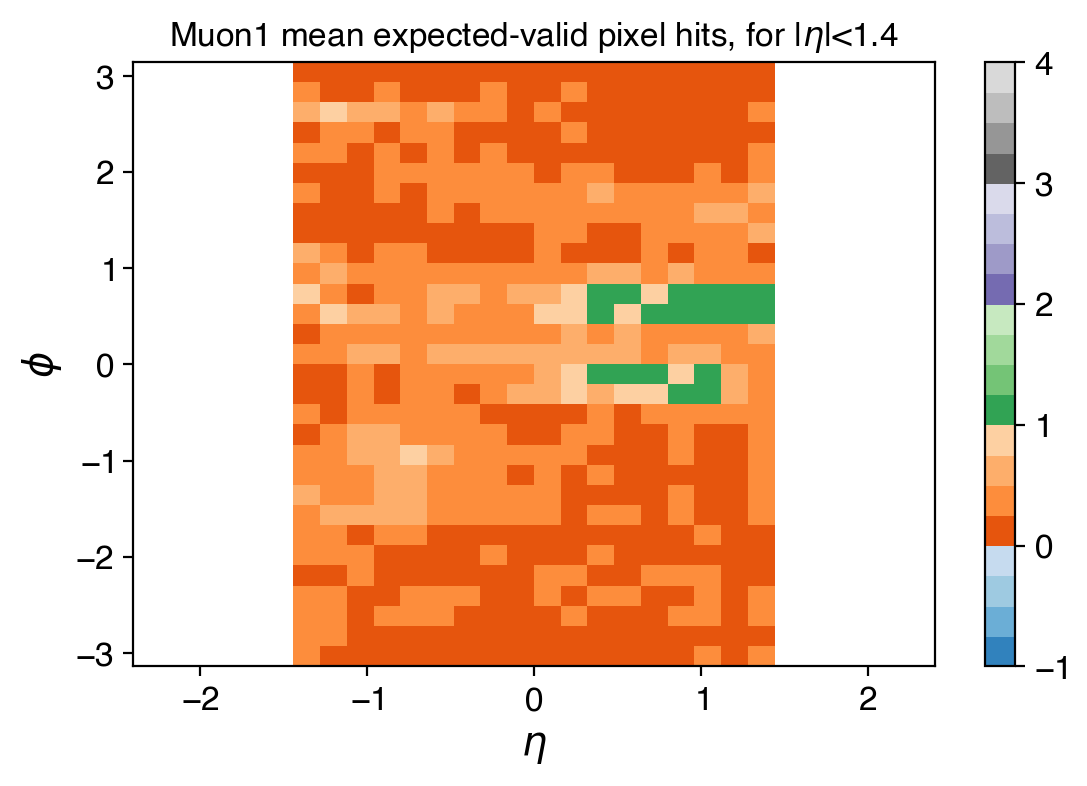

In [277]:
df = df_mc.query("abs(Muon1_eta) < 1.4")
# df = df_data.query("abs(Muon1_eta) < 1.4")

mat = np.c_[df["Muon1_eta"],df["Muon1_phi"]]
bins = [np.linspace(-2.4,2.4,31),np.linspace(-np.pi,np.pi,31)]

hnum = Hist2D(mat, bins=bins, weights=df.eval("Muon1_nExpectedPixelHits-Muon1_nValidPixelHits"))
hden = Hist2D(mat, bins=bins)

fig, ax = plt.subplots()
ratio = (hnum/hden)
ratio.plot(ax=ax,cmap="tab20c",vmin=-1.0,vmax=4.0)
# ratio.plot(ax=ax,cmap="coolwarm",vmin=0.0,vmax=3.0)
ax.set_title("Muon1 mean expected-valid pixel hits, for |$\eta$|<1.4")
ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$\phi$")

## Play

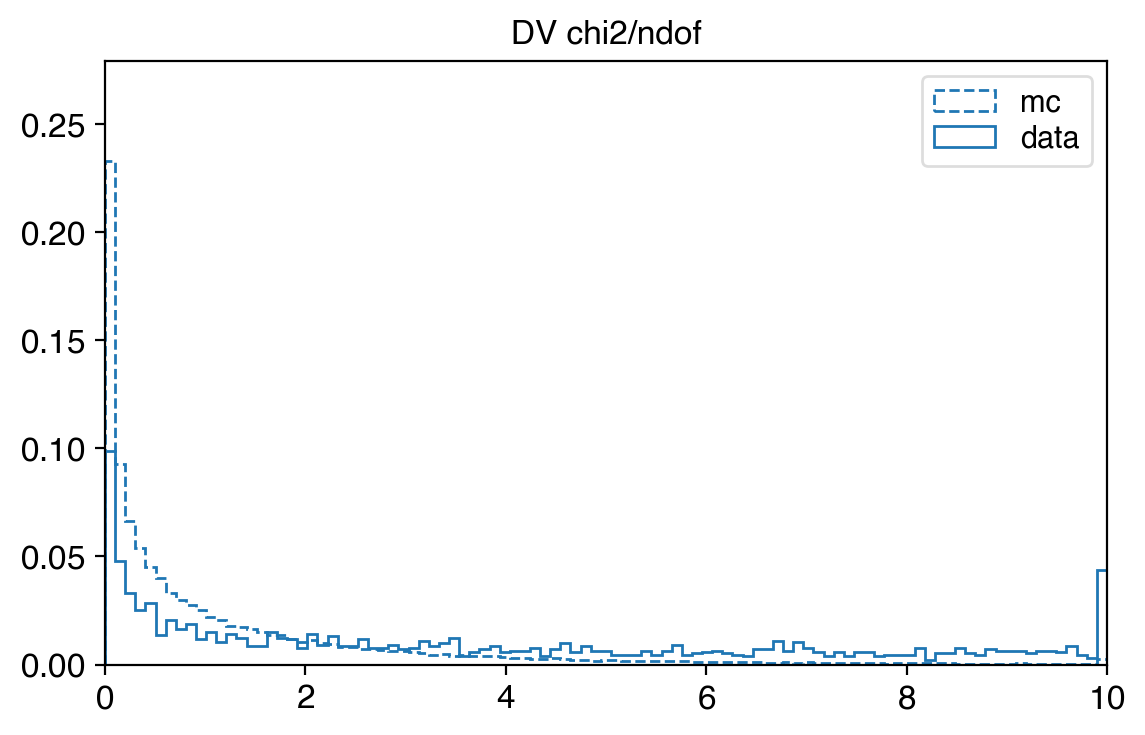

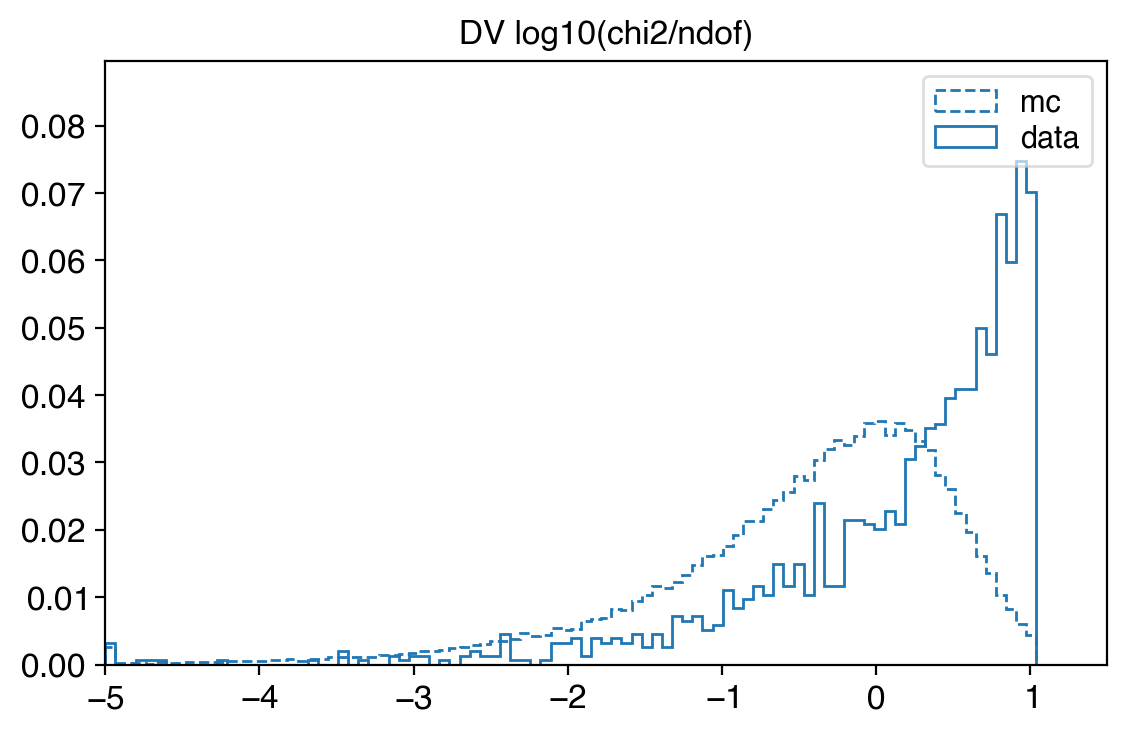

In [291]:
plots = [
    
#     [[lambda df: np.abs(df["Muon1_dxyCorr"]),lambda df: np.abs(df["Muon2_dxyCorr"])], np.linspace(0.0,6,150), dict(title="abs(Muon dxy)",logy=True,logx=True,shortname="absdxy")],
#     [[lambda df: df["Muon1_dxyCorr"],lambda df: df["Muon2_dxyCorr"]], np.linspace(-5,5,150), dict(title="(signed) Muon dxy",logy=True,shortname="signeddxy")],
#     [[lambda df: df["Muon1_dxyError"],lambda df: df["Muon2_dxyError"]], np.linspace(0.001,0.02,150), dict(title="Muon dxy Error",logy=True,shortname="dxyError")],
    
#     [[lambda df: df["Muon1_nValidPixelHits"],lambda df: df["Muon2_nValidPixelHits"]], np.arange(10)-0.5, dict(title="Muon nValidPixelHits",shortname="nValidPixelHits")],
#     [[lambda df: df["Muon1_nValidStripHits"],lambda df: df["Muon2_nValidStripHits"]], np.arange(50)-0.5, dict(title="Muon nValidStripHits",shortname="nValidStripHits")],
#     [[lambda df: df["Muon1_nExpectedPixelHits"],lambda df: df["Muon2_nExpectedPixelHits"]], np.arange(12)-0.5, dict(title="Muon nExpectedPixelHits",shortname="nExpectedPixelHits")],
#     [[lambda df: df.eval("Muon1_nValidPixelHits-Muon1_nExpectedPixelHits"),lambda df: df.eval("Muon2_nValidPixelHits-Muon2_nExpectedPixelHits")], np.arange(10)-5.5, dict(title="Muon nValidPixelHits-nExpectedPixelHits",shortname="nValidMinusExpectedPixelHits")],
    
#     [[lambda df: df["absdphimumu"]], np.linspace(0,3.1416,150), dict(title="abs(dphi(mu1,mu2))",shortname="dphimumu")],
#     [[lambda df: df["absdphimumu"]], np.linspace(0,3.1416,150), dict(title="abs(dphi(mu1,mu2)), logscale",logx=True,logy=True,shortname="dphimumulog")],
    [[lambda df: df["DV_redchi2"]], np.linspace(0.0,10.0,100), dict(title="DV chi2/ndof",shortname="DVchi2")],
    [[lambda df: np.log10(df["DV_redchi2"])], np.linspace(-5,1.5,100), dict(title="DV log10(chi2/ndof)",shortname="DVlogchi2")],
]

varexp = "dimuon_mass>10"
for fs,bins,opts in plots:
    fig,ax = plt.subplots()

    ymax = 0.
    for df,label,linestyle in [
        [df_mc,"mc","--"],
        [df_data,"data","-"],
    ]:
        df = df.query(varexp)

        color = "C0"

        h = sum([Hist1D(f(df),bins=bins) for f in fs]).normalize()
        h.plot(ax=ax,label="{}".format(label),color=color,histtype="step",linestyle=linestyle);
        ymax = max(ymax,h.counts.max())

    if opts.get("logx"):
        ax.set_xscale("log")

    if opts.get("logy"):
        ax.set_ylim(0.00001,ymax*1.5)
        ax.set_yscale("log")
    else:
        ax.set_ylim(ax.get_ylim()[0],ymax*1.2)

    ax.set_title(opts.get("title",""))
    ax.legend()

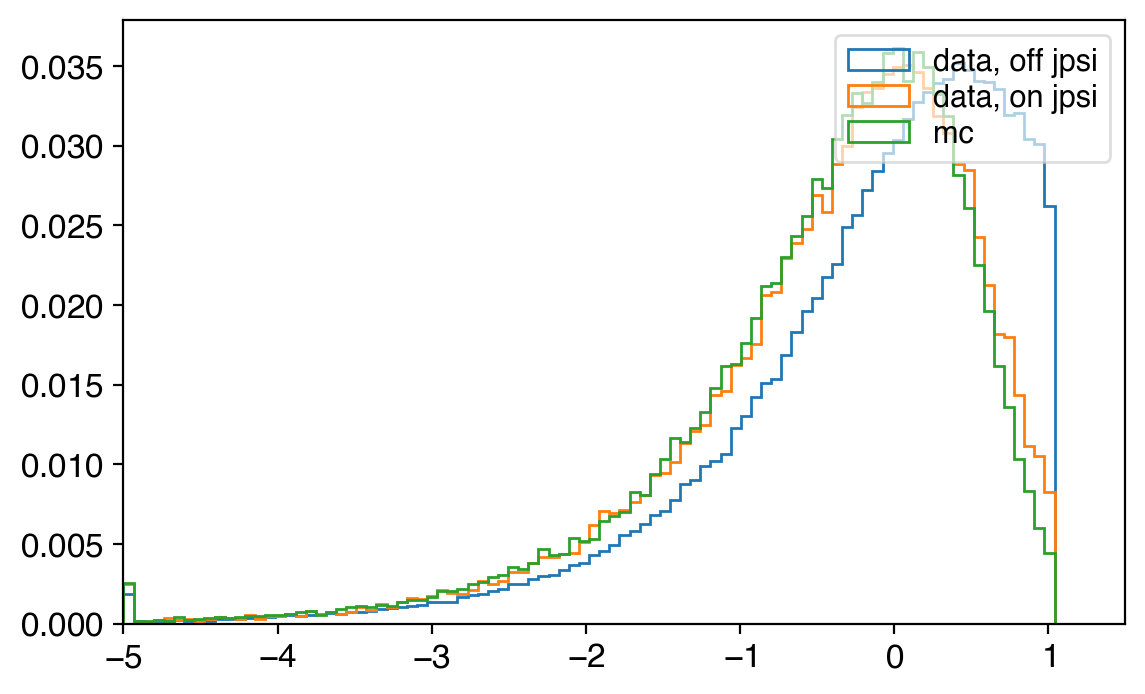

In [310]:
# Hist1D(df_data.query("2.95<dimuon_mass<3.2")["dimuon_mass"],bins=np.linspace(2.95,3.2,100))
bins = np.linspace(-5,1.5,100)
fig, ax = plt.subplots()
Hist1D(df_data.query("not(2.95<dimuon_mass<3.2)").eval("log10(DV_redchi2)"),bins=bins).normalize().plot(ax=ax,histtype="step",label="data, off jpsi")
Hist1D(df_data.query("2.95<dimuon_mass<3.2").eval("log10(DV_redchi2)"),bins=bins).normalize().plot(ax=ax,histtype="step",label="data, on jpsi")
Hist1D(df_mc.eval("log10(DV_redchi2)"),bins=bins).normalize().plot(ax=ax,histtype="step",label="mc")
ax.legend()